In [1]:
#TO DO: FINALIZE CHART TITLES
#TO DO: SAVE FIGURES WHEN COMPLETE
#ENSURE ALL VERTICAL SCROLLING IS OFF SO THAT THE CELLS CAN BE VIEWED IN ENTIRETY (cELL > CURRENT OUTPUTS > TOGGLE SCROLLING)

### Explore the relationship between air quality and asthma at the county level for California

In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
%matplotlib inline

#### California air quality and asthma

In previous studies, California counties were found to have high PM2.5, ozone, and AQI indices. In addition, most counties in California have AQI monitoring sites. Unfortunately, there were no California asthma datasets by county for the years 1999, 2012, or 2020. California reports asthma in two-year periods, the most recent asthma data is for 2017-2018. For this study, I will read in 2017 and 2018 daily PM2.5 datasets, daily ozone datasets, and annual AQI datasets. I'll limit the datasets to California and follow procedures in previous studies for cleaning. Then I'll join the datasets to explore relationships between air quality and asthma.

### Read in datafiles, clean data, and print descriptive statistics

#### PM2.5

In [187]:
pm2017 = pd.read_csv('C:\\Users\\Mary\\CIS5898\\daily_88101_2017.csv') 
pm2018 = pd.read_csv('C:\\Users\\Mary\\CIS5898\\daily_88101_2018.csv') 

In [188]:
pm2017.columns

Index(['State Code', 'County Code', 'Site Num', 'Parameter Code', 'POC',
       'Latitude', 'Longitude', 'Datum', 'Parameter Name', 'Sample Duration',
       'Pollutant Standard', 'Date Local', 'Units of Measure', 'Event Type',
       'Observation Count', 'Observation Percent', 'Arithmetic Mean',
       '1st Max Value', '1st Max Hour', 'AQI', 'Method Code', 'Method Name',
       'Local Site Name', 'Address', 'State Name', 'County Name', 'City Name',
       'CBSA Name', 'Date of Last Change'],
      dtype='object')

In [189]:
pm2017California = pm2017[pm2017['State Name'] == 'California']


In [190]:
pm2018California = pm2018[pm2018['State Name'] == 'California']

In [191]:
print(len(pm2017California))
print(len(pm2018California))

62774
66371


In [192]:
pmCaliforniaCombined = pm2017California.append(pm2018California)

Follow steps for cleaning previous PM2.5 files: <br>
(1) removal of all 1 hour samples, <br>
(2) removal of excluded event observations, <br>
(3) removal of 24-hour block averages when a site reports both 24-hour block average and 24 hour concentrations on the same date

In [193]:
#Check whether there are multiple sample durations
pmCaliforniaCombined.groupby('Sample Duration').size()

Sample Duration
1 HOUR           55105
24 HOUR          19949
24-HR BLK AVG    54091
dtype: int64

In [212]:
#remove 1 hour samples
pmCaliforniaCombinedNon1HR = pmCaliforniaCombined[pmCaliforniaCombined['Sample Duration'] !=  '1 HOUR']
len(pmCaliforniaCombinedNon1HR)

74040

In [213]:
#Check whether there are excluded observations in event type. 
pmCaliforniaCombinedNon1HR.groupby('Event Type').size()

Event Type
Excluded       84
Included     3702
None        70254
dtype: int64

In [214]:
#remove excluded event type observations
pmCaliforniaCombinedNon1HRNonExcluded = pmCaliforniaCombinedNon1HR[pmCaliforniaCombinedNon1HR['Event Type'] !=  'Excluded']
len(pmCaliforniaCombinedNon1HRNonExcluded)

73956

In [215]:
#sort df
pmCaliforniaCombinedNon1HRNonExcludedSorted = pmCaliforniaCombinedNon1HRNonExcluded.sort_values(by=['County Code', 'Site Num', 'Date Local'])

In [217]:
#remove 24-hour block averages when a site reports both 24-hour block average and 24 hour concentrations on the same date
pmCaliforniaCombinedCleaned = pmCaliforniaCombinedNon1HRNonExcludedSorted.drop_duplicates(subset=['County Code','Site Num', 'Date Local'],
            keep='first')
len(pmCaliforniaCombinedCleaned)

63532

In [218]:
#save cleaned dataset 
pmCaliforniaCombinedCleaned.to_csv('C:\\Users\\Mary\\CIS5898\\FIT_capstone\\daily_88101_20117_2018_California_cleaned.csv', header = True)

In [219]:
#group by county
pmCaliforniaCombinedCounty = pmCaliforniaCombinedCleaned['Arithmetic Mean'].groupby(pmCaliforniaCombinedCleaned['County Name']).mean()

In [220]:
pmCaliforniaCombinedCountydf = pd.DataFrame(pmCaliforniaCombinedCounty.to_frame().reset_index())
pmCaliforniaCombinedCountydf

,County Name,Arithmetic Mean
0,Alameda,11.708453
1,Butte,11.508597
2,Calaveras,14.154899
3,Colusa,7.727910
4,Contra Costa,12.271067
5,Del Norte,6.538642
6,Fresno,12.819508
7,Humboldt,6.891257
8,Imperial,11.121807
9,Inyo,6.606611


In [221]:
#rename columns
pmCaliforniaCombinedCountydf = pmCaliforniaCombinedCountydf.rename(columns={'County Name': 'County', 'Arithmetic Mean': 'PM2.5 Mean'}).copy()

In [222]:
pmCaliforniaCombinedCountydf.describe()

,PM2.5 Mean
count,47.000000
mean,10.580729
std,2.952941
min,6.054789
25%,8.283897
50%,10.671308
75%,12.088714
max,18.688235


In [223]:
pmCaliforniaCombinedCountydf.sort_values('PM2.5 Mean', ascending=False)

,County,PM2.5 Mean
38,Siskiyou,18.688235
11,Kings,17.106061
44,Tulare,16.847748
41,Stanislaus,14.550314
2,Calaveras,14.154899
17,Merced,14.043474
31,San Joaquin,13.612896
14,Madera,13.373199
6,Fresno,12.819508
20,Napa,12.580758


#### Ozone

In [224]:
ozone2017 = pd.read_csv('C:\\Users\\Mary\\CIS5898\\daily_44201_2017.csv') 
ozone2018 = pd.read_csv('C:\\Users\\Mary\\CIS5898\\daily_44201_2018.csv') 

In [225]:
ozone2017California = ozone2017[ozone2017['State Name'] == 'California']

In [226]:
ozone2018California = ozone2018[ozone2018['State Name'] == 'California']

In [227]:
print(len(ozone2017California))
print(len(ozone2018California))

59262
60514


In [228]:
ozoneCaliforniaCombined = ozone2017California.append(ozone2018California)

Follow steps for cleaning previous ozone files: <br>
(1) removal of excluded event observations, <br>

In [229]:
#Check whether there are excluded observations in event type
ozoneCaliforniaCombined.groupby('Event Type').size()

Event Type
Excluded        14
Included      6609
None        113153
dtype: int64

In [231]:
#remove excluded event type observations
ozoneCaliforniaCombinedCleaned = ozoneCaliforniaCombined[ozoneCaliforniaCombined['Event Type'] !=  'Excluded']
len(ozoneCaliforniaCombinedCleaned)

119762

In [232]:
#save cleaned dataset 
ozoneCaliforniaCombinedCleaned.to_csv('C:\\Users\\Mary\\CIS5898\\FIT_capstone\\daily_44201_2017_2018_California_cleaned.csv', header = True)

In [239]:
#group by county
ozoneCaliforniaCombinedCounty = ozoneCaliforniaCombinedCleaned['Arithmetic Mean'].groupby(ozoneCaliforniaCombinedCleaned['County Name']).mean()

In [240]:
ozoneCaliforniaCombinedCountydf = pd.DataFrame(ozoneCaliforniaCombinedCounty.to_frame().reset_index())
ozoneCaliforniaCombinedCountydf

,County Name,Arithmetic Mean
0,Alameda,0.023923
1,Amador,0.028930
2,Butte,0.037306
3,Calaveras,0.034399
4,Colusa,0.029574
5,Contra Costa,0.026690
6,El Dorado,0.043808
7,Fresno,0.035092
8,Glenn,0.028895
9,Humboldt,0.025429


In [241]:
#rename columns
ozoneCaliforniaCombinedCountydf = ozoneCaliforniaCombinedCountydf.rename(columns={'County Name': 'County', 'Arithmetic Mean': 'Ozone Mean'}).copy()

In [242]:
ozoneCaliforniaCombinedCountydf.describe()

,Ozone Mean
count,49.000000
mean,0.031590
std,0.006073
min,0.022420
25%,0.026972
50%,0.030703
75%,0.034474
max,0.047782


In [244]:
ozoneCaliforniaCombinedCountydf.sort_values('Ozone Mean', ascending=False)

,County,Ozone Mean
23,Nevada,0.047782
18,Mariposa,0.046664
6,El Dorado,0.043808
29,San Bernardino,0.041469
45,Tulare,0.039893
12,Kern,0.039554
44,Tehama,0.039456
26,Riverside,0.039365
2,Butte,0.037306
46,Tuolumne,0.036516


#### AQI

In [71]:
AQI2017 = pd.read_csv('C:\\Users\\Mary\\CIS5898\\annual_aqi_by_county_2017.csv') 
AQI2018 = pd.read_csv('C:\\Users\\Mary\\CIS5898\\annual_aqi_by_county_2018.csv') 

In [72]:
AQI2017.columns

Index(['State', 'County', 'Year', 'Days with AQI', 'Good Days',
       'Moderate Days', 'Unhealthy for Sensitive Groups Days',
       'Unhealthy Days', 'Very Unhealthy Days', 'Hazardous Days', 'Max AQI',
       '90th Percentile AQI', 'Median AQI', 'Days CO', 'Days NO2',
       'Days Ozone', 'Days SO2', 'Days PM2.5', 'Days PM10'],
      dtype='object')

In [73]:
AQI2017California = AQI2017[AQI2017['State'] == 'California']

In [74]:
AQI2018California = AQI2018[AQI2018['State'] == 'California']

In [75]:
print(len(AQI2017California))
print(len(AQI2018California))

53
53


In [76]:
AQI2017California.describe()

,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days SO2,Days PM2.5,Days PM10
count,53.0,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.0,53.000000,53.000000,53.000000,53.000000,53.000000
mean,2017.0,357.283019,205.264151,118.603774,24.867925,6.981132,1.037736,0.528302,288.301887,88.433962,49.037736,0.0,3.981132,212.849057,0.018868,122.962264,17.471698
std,0.0,30.233945,81.266454,55.456615,29.164017,11.551707,3.441613,2.232658,516.520183,31.554294,15.161898,0.0,9.030910,87.371971,0.137361,73.873323,49.092379
min,2017.0,203.000000,31.000000,10.000000,0.000000,0.000000,0.000000,0.000000,117.000000,44.000000,18.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2017.0,365.000000,152.000000,82.000000,6.000000,1.000000,0.000000,0.000000,154.000000,64.000000,39.000000,0.0,0.000000,172.000000,0.000000,94.000000,0.000000
50%,2017.0,365.000000,221.000000,111.000000,9.000000,3.000000,0.000000,0.000000,169.000000,82.000000,45.000000,0.0,0.000000,219.000000,0.000000,116.000000,2.000000
75%,2017.0,365.000000,273.000000,168.000000,33.000000,6.000000,0.000000,0.000000,197.000000,100.000000,54.000000,0.0,2.000000,253.000000,0.000000,155.000000,14.000000
max,2017.0,365.000000,350.000000,220.000000,115.000000,51.000000,23.000000,15.000000,3439.000000,185.000000,87.000000,0.0,47.000000,362.000000,1.000000,351.000000,341.000000


In [77]:
AQI2018California.describe()

,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days SO2,Days PM2.5,Days PM10
count,53.0,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000
mean,2018.0,359.207547,206.566038,118.377358,23.226415,9.679245,1.132075,0.226415,231.113208,87.320755,48.792453,0.037736,4.113208,201.641509,0.018868,138.679245,14.716981
std,0.0,27.214503,83.329630,60.999441,27.851006,9.281441,1.829646,0.669142,136.877635,27.802721,14.714408,0.192380,8.554487,88.386628,0.137361,75.463127,30.029074
min,2018.0,180.000000,35.000000,7.000000,0.000000,0.000000,0.000000,0.000000,77.000000,43.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2018.0,365.000000,153.000000,70.000000,5.000000,5.000000,0.000000,0.000000,166.000000,64.000000,39.000000,0.000000,0.000000,154.000000,0.000000,94.000000,0.000000
50%,2018.0,365.000000,219.000000,115.000000,14.000000,8.000000,0.000000,0.000000,196.000000,84.000000,45.000000,0.000000,0.000000,203.000000,0.000000,136.000000,1.000000
75%,2018.0,365.000000,275.000000,171.000000,26.000000,11.000000,2.000000,0.000000,240.000000,101.000000,54.000000,0.000000,2.000000,246.000000,0.000000,192.000000,12.000000
max,2018.0,365.000000,347.000000,257.000000,103.000000,51.000000,8.000000,4.000000,994.000000,164.000000,88.000000,1.000000,34.000000,364.000000,1.000000,350.000000,147.000000


#### Asthma

This is a new dataset, so I will look more closely at it than the air quality datasets which I've looked at more closely in previous studies.

In [78]:
asthmaCalifornia = pd.read_excel('C:\\Users\\Mary\\CIS5898\\current-asthma-prevalence-by-county-2015_2018 (2).xlsx') 

In [79]:
asthmaCalifornia.head()

,COUNTY,YEARS,STRATA,AGE GROUP,CURRENT PREVALENCE,95% CONFIDENCE INTERVAL,COUNTIES GROUPED,COMMENT
0,California,2015–2016,Total population,All ages,0.086958,(8.1–9.3),NaN,NaN
1,Alameda,2015–2016,Total population,All ages,0.090542,(5.9–12.2),NaN,NaN
2,Alpine,2015–2016,Total population,All ages,0.093000,(4.1–14.6),"Alpine, Amador, Calaveras, Inyo, Mariposa, Mon...",NaN
3,Amador,2015–2016,Total population,All ages,0.093000,(4.1–14.6),"Alpine, Amador, Calaveras, Inyo, Mariposa, Mon...",NaN
4,Butte,2015–2016,Total population,All ages,0.094291,(3.8–15.1),NaN,Estimate is statistically unstable. Caution is...


In [80]:
print(asthmaCalifornia.info()) #provides basic information on data
print(asthmaCalifornia.ndim) #provides dimensions
print(asthmaCalifornia.shape) #provides number of rows and number of columns 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 826 entries, 0 to 825
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   COUNTY                   826 non-null    object 
 1   YEARS                    826 non-null    object 
 2   STRATA                   826 non-null    object 
 3   AGE GROUP                826 non-null    object 
 4   CURRENT PREVALENCE       457 non-null    float64
 5   95% CONFIDENCE INTERVAL  457 non-null    object 
 6   COUNTIES GROUPED         238 non-null    object 
 7   COMMENT                  622 non-null    object 
dtypes: float64(1), object(7)
memory usage: 51.8+ KB
None
2
(826, 8)


In [81]:
asthmaCalifornia.groupby('YEARS').size()

YEARS
2015–2016    413
2017–2018    413
dtype: int64

In [82]:
#Limit the years to 2017-2018
asthmaCalifornia['YEARS'].describe

<bound method NDFrame.describe of 0      2015–2016
1      2015–2016
2      2015–2016
3      2015–2016
4      2015–2016
         ...    
821    2017–2018
822    2017–2018
823    2017–2018
824    2017–2018
825    2017–2018
Name: YEARS, Length: 826, dtype: object>

In [83]:
asthmaCalifornia['YEARS'].dtype

dtype('O')

In [84]:
asthmaCal17_18 = asthmaCalifornia[asthmaCalifornia['YEARS'] == '2017–2018'].copy()

In [85]:
len(asthmaCal17_18)

413

In [86]:
asthmaCal17_18.head()

,COUNTY,YEARS,STRATA,AGE GROUP,CURRENT PREVALENCE,95% CONFIDENCE INTERVAL,COUNTIES GROUPED,COMMENT
413,California,2017–2018,Total population,All ages,0.088228,(8.2–9.4),NaN,NaN
414,Alameda,2017–2018,Total population,All ages,0.087699,(5.3–12.2),NaN,NaN
415,Alpine,2017–2018,Total population,All ages,0.135805,(4.5–22.7),"Alpine, Amador, Calaveras, Inyo, Mariposa, Mon...",Estimate is statistically unstable. Caution is...
416,Amador,2017–2018,Total population,All ages,0.135805,(4.5–22.7),"Alpine, Amador, Calaveras, Inyo, Mariposa, Mon...",Estimate is statistically unstable. Caution is...
417,Butte,2017–2018,Total population,All ages,0.110033,(4.1–17.9),NaN,Estimate is statistically unstable. Caution is...


In [87]:
asthmaCal17_18.groupby('STRATA').size()

STRATA
Age groups          236
Child vs. adult     118
Total population     59
dtype: int64

In [88]:
#In previous studies, the age used was 18+. Look at child vs adult.
asthmaCal17_18ChildvsAdult = asthmaCal17_18[asthmaCal17_18['STRATA'] == 'Child vs. adult'].copy()
asthmaCal17_18ChildvsAdult

,COUNTY,YEARS,STRATA,AGE GROUP,CURRENT PREVALENCE,95% CONFIDENCE INTERVAL,COUNTIES GROUPED,COMMENT
472,California,2017–2018,Child vs. adult,0–17 years,0.080354,(6.4–9.6),NaN,NaN
473,Alameda,2017–2018,Child vs. adult,0–17 years,0.095354,(1.5–17.6),NaN,Estimate is statistically unstable. Caution is...
474,Alpine,2017–2018,Child vs. adult,0–17 years,NaN,NaN,"Alpine, Amador, Calaveras, Inyo, Mariposa, Mon...",Prevalence not available due to unreliable est...
475,Amador,2017–2018,Child vs. adult,0–17 years,NaN,NaN,"Alpine, Amador, Calaveras, Inyo, Mariposa, Mon...",Prevalence not available due to unreliable est...
476,Butte,2017–2018,Child vs. adult,0–17 years,NaN,NaN,NaN,Prevalence not available due to unreliable est...
...,...,...,...,...,...,...,...,...
585,Tulare,2017–2018,Child vs. adult,18+ years,0.079534,(3.2–12.7),NaN,NaN
586,Tuolumne,2017–2018,Child vs. adult,18+ years,0.175692,(6.7–28.5),"Alpine, Amador, Calaveras, Inyo, Mariposa, Mon...",Estimate is statistically unstable. Caution is...
587,Ventura,2017–2018,Child vs. adult,18+ years,0.058988,(3.1–8.7),NaN,NaN
588,Yolo,2017–2018,Child vs. adult,18+ years,0.143217,(4.9–23.8),NaN,Estimate is statistically unstable. Caution is...


In [89]:
#limit the dataset to age group of 18+
asthmaCal17_18ChildvsAdult18Plus = asthmaCal17_18ChildvsAdult[asthmaCal17_18ChildvsAdult['AGE GROUP'] == '18+ years'].copy()
asthmaCal17_18ChildvsAdult18Plus

,COUNTY,YEARS,STRATA,AGE GROUP,CURRENT PREVALENCE,95% CONFIDENCE INTERVAL,COUNTIES GROUPED,COMMENT
531,California,2017–2018,Child vs. adult,18+ years,0.090679,(8.4–9.7),NaN,NaN
532,Alameda,2017–2018,Child vs. adult,18+ years,0.085585,(5.5–11.6),NaN,NaN
533,Alpine,2017–2018,Child vs. adult,18+ years,0.175692,(6.7–28.5),"Alpine, Amador, Calaveras, Inyo, Mariposa, Mon...",Estimate is statistically unstable. Caution is...
534,Amador,2017–2018,Child vs. adult,18+ years,0.175692,(6.7–28.5),"Alpine, Amador, Calaveras, Inyo, Mariposa, Mon...",Estimate is statistically unstable. Caution is...
535,Butte,2017–2018,Child vs. adult,18+ years,0.129290,(6.3–19.5),NaN,NaN
536,Calaveras,2017–2018,Child vs. adult,18+ years,0.175692,(6.7–28.5),"Alpine, Amador, Calaveras, Inyo, Mariposa, Mon...",Estimate is statistically unstable. Caution is...
537,Colusa,2017–2018,Child vs. adult,18+ years,0.148277,(6.6–23.0),"Colusa, Glenn, and Tehama counties combined co...",NaN
538,Contra Costa,2017–2018,Child vs. adult,18+ years,0.134571,(9.1–17.8),NaN,NaN
539,Del Norte,2017–2018,Child vs. adult,18+ years,0.138676,(4.9–22.9),"Del Norte, Lassen, Modoc, Plumas, Sierra, Sisk...",Estimate is statistically unstable. Caution is...
540,El Dorado,2017–2018,Child vs. adult,18+ years,0.090343,(1.8–16.3),NaN,Estimate is statistically unstable. Caution is...


In [90]:
#convert current prevalence column to percent (multiply by 100)
asthmaCal17_18ChildvsAdult18Plus.loc[:,'CURRENT PREVALENCE']*=100

In [91]:
asthmaCal17_18ChildvsAdult18Plus

,COUNTY,YEARS,STRATA,AGE GROUP,CURRENT PREVALENCE,95% CONFIDENCE INTERVAL,COUNTIES GROUPED,COMMENT
531,California,2017–2018,Child vs. adult,18+ years,9.0679,(8.4–9.7),NaN,NaN
532,Alameda,2017–2018,Child vs. adult,18+ years,8.5585,(5.5–11.6),NaN,NaN
533,Alpine,2017–2018,Child vs. adult,18+ years,17.5692,(6.7–28.5),"Alpine, Amador, Calaveras, Inyo, Mariposa, Mon...",Estimate is statistically unstable. Caution is...
534,Amador,2017–2018,Child vs. adult,18+ years,17.5692,(6.7–28.5),"Alpine, Amador, Calaveras, Inyo, Mariposa, Mon...",Estimate is statistically unstable. Caution is...
535,Butte,2017–2018,Child vs. adult,18+ years,12.9290,(6.3–19.5),NaN,NaN
536,Calaveras,2017–2018,Child vs. adult,18+ years,17.5692,(6.7–28.5),"Alpine, Amador, Calaveras, Inyo, Mariposa, Mon...",Estimate is statistically unstable. Caution is...
537,Colusa,2017–2018,Child vs. adult,18+ years,14.8277,(6.6–23.0),"Colusa, Glenn, and Tehama counties combined co...",NaN
538,Contra Costa,2017–2018,Child vs. adult,18+ years,13.4571,(9.1–17.8),NaN,NaN
539,Del Norte,2017–2018,Child vs. adult,18+ years,13.8676,(4.9–22.9),"Del Norte, Lassen, Modoc, Plumas, Sierra, Sisk...",Estimate is statistically unstable. Caution is...
540,El Dorado,2017–2018,Child vs. adult,18+ years,9.0343,(1.8–16.3),NaN,Estimate is statistically unstable. Caution is...


In [92]:
len(asthmaCal17_18ChildvsAdult18Plus)

59

In [93]:
#check whether there are any missing values from the current prevalence column
asthmaCal17_18ChildvsAdult18Plus['CURRENT PREVALENCE'].isna().any()

True

In [94]:
asthmaCal17_18ChildvsAdult18Plus['CURRENT PREVALENCE'].isna()

531    False
532    False
533    False
534    False
535    False
536    False
537    False
538    False
539    False
540    False
541    False
542    False
543    False
544    False
545    False
546    False
547    False
548    False
549    False
550    False
551    False
552    False
553    False
554    False
555    False
556    False
557    False
558    False
559    False
560    False
561    False
562    False
563    False
564    False
565    False
566     True
567    False
568    False
569    False
570    False
571    False
572    False
573     True
574    False
575    False
576    False
577    False
578    False
579    False
580    False
581    False
582    False
583    False
584    False
585    False
586    False
587    False
588    False
589    False
Name: CURRENT PREVALENCE, dtype: bool

In [95]:
asthmaCal17_18ChildvsAdult18Plus.drop([566, 573], inplace=True)

In [96]:
asthmaCal17_18ChildvsAdult18Plus.describe()

,CURRENT PREVALENCE
count,57.000000
mean,11.877828
std,3.663685
min,5.840300
25%,8.595700
50%,12.355000
75%,13.867600
max,19.675200


In [97]:
#rename df
asthmaCalFinal = asthmaCal17_18ChildvsAdult18Plus

In [98]:
#sort asthma prevalence by county from high to low
#asthmaCal17_18ChildvsAdult18Plus.sort_values('CURRENT PREVALENCE', ascending = False)
asthmaCalFinal.sort_values('CURRENT PREVALENCE', ascending = False)

,COUNTY,YEARS,STRATA,AGE GROUP,CURRENT PREVALENCE,95% CONFIDENCE INTERVAL,COUNTIES GROUPED,COMMENT
582,Sutter,2017–2018,Child vs. adult,18+ years,19.6752,(10.9–28.5),NaN,NaN
545,Inyo,2017–2018,Child vs. adult,18+ years,17.5692,(6.7–28.5),"Alpine, Amador, Calaveras, Inyo, Mariposa, Mon...",Estimate is statistically unstable. Caution is...
533,Alpine,2017–2018,Child vs. adult,18+ years,17.5692,(6.7–28.5),"Alpine, Amador, Calaveras, Inyo, Mariposa, Mon...",Estimate is statistically unstable. Caution is...
534,Amador,2017–2018,Child vs. adult,18+ years,17.5692,(6.7–28.5),"Alpine, Amador, Calaveras, Inyo, Mariposa, Mon...",Estimate is statistically unstable. Caution is...
586,Tuolumne,2017–2018,Child vs. adult,18+ years,17.5692,(6.7–28.5),"Alpine, Amador, Calaveras, Inyo, Mariposa, Mon...",Estimate is statistically unstable. Caution is...
536,Calaveras,2017–2018,Child vs. adult,18+ years,17.5692,(6.7–28.5),"Alpine, Amador, Calaveras, Inyo, Mariposa, Mon...",Estimate is statistically unstable. Caution is...
557,Mono,2017–2018,Child vs. adult,18+ years,17.5692,(6.7–28.5),"Alpine, Amador, Calaveras, Inyo, Mariposa, Mon...",Estimate is statistically unstable. Caution is...
553,Mariposa,2017–2018,Child vs. adult,18+ years,17.5692,(6.7–28.5),"Alpine, Amador, Calaveras, Inyo, Mariposa, Mon...",Estimate is statistically unstable. Caution is...
559,Napa,2017–2018,Child vs. adult,18+ years,16.1360,(5.2–27.0),NaN,Estimate is statistically unstable. Caution is...
589,Yuba,2017–2018,Child vs. adult,18+ years,15.9095,(8.1–23.7),NaN,NaN


In [99]:
len(asthmaCalFinal)

57

### Create maps of PM2.5, ozone, and asthma by California county

In [100]:
#read in U.S. county map
countyMap = gpd.read_file('C:\\Users\\Mary\\CIS5898\\cb_2014_us_county_5m\\cb_2014_us_county_5m.shp')
countyMap.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,01,059,00161555,0500000US01059,01059,Franklin,06,1641580723,32904833,"POLYGON Z ((-88.16591 34.38093 0.00000, -88.16..."
1,13,111,00351094,0500000US13111,13111,Fannin,06,1002370118,13560697,"POLYGON Z ((-84.62148 34.98833 0.00000, -84.50..."
2,19,109,00465243,0500000US19109,19109,Kossuth,06,2519332669,4154722,"POLYGON Z ((-94.44314 43.25501 0.00000, -94.44..."
3,40,115,01101845,0500000US40115,40115,Ottawa,06,1219467406,35708892,"POLYGON Z ((-95.03412 36.99423 0.00000, -95.00..."
4,42,115,01213688,0500000US42115,42115,Susquehanna,06,2132881515,22356541,"POLYGON Z ((-76.13120 41.99895 0.00000, -76.12..."


In [101]:
#limit map to California
#Per https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013696, the STATEFP for California is 06
californiaCountyMap = countyMap[countyMap['STATEFP']== '06']

In [102]:
len(californiaCountyMap)

58

In [245]:
#merge California county map with mean PM2.5
calPM25Map = pd.merge(californiaCountyMap, pmCaliforniaCombinedCountydf, left_on=californiaCountyMap['NAME'], 
                right_on=pmCaliforniaCombinedCountydf['County'], how='left')
calPM25Map.head()

,key_0,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,County,PM2.5 Mean
0,Trinity,06,105,00277317,0500000US06105,06105,Trinity,06,8234308375,73407838,"POLYGON Z ((-123.62366 40.92982 0.00000, -123....",NaN,NaN
1,San Luis Obispo,06,079,00277304,0500000US06079,06079,San Luis Obispo,06,8543720566,820409436,"POLYGON Z ((-121.34636 35.79518 0.00000, -121....",San Luis Obispo,7.466846
2,Shasta,06,089,01682610,0500000US06089,06089,Shasta,06,9778188425,186530226,"POLYGON Z ((-123.06644 40.33621 0.00000, -123....",Shasta,11.108257
3,Amador,06,005,01675841,0500000US06005,06005,Amador,06,1539947591,29470575,"POLYGON Z ((-121.02751 38.50829 0.00000, -121....",NaN,NaN
4,San Bernardino,06,071,00277300,0500000US06071,06071,San Bernardino,06,51947497395,123929658,"POLYGON Z ((-117.78506 34.00481 0.00000, -117....",San Bernardino,11.231331


<AxesSubplot:title={'center':'California Mean PM2.5 by County\n 2017-2918'}>

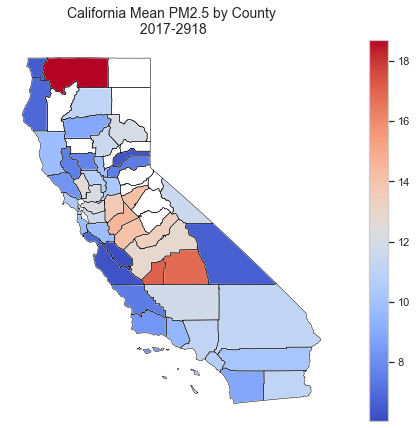

In [248]:
#plot PM2.5 map
fig = plt.figure(1, figsize=(12,7)) 
ax = fig.add_subplot()
ax.set_title('California Mean PM2.5 by County\n 2017-2918', fontsize=14)
ax.set_axis_off()

californiaCountyMap.boundary.plot(ax=ax, color = 'black', linewidth=.5)
calPM25Map.plot(ax = ax, column='PM2.5 Mean', legend=True,cmap='coolwarm')

In [247]:
plt.close()

In [249]:
#merge California county map with mean ozone
calOzoneMap = pd.merge(californiaCountyMap, ozoneCaliforniaCombinedCountydf, left_on=californiaCountyMap['NAME'], 
                right_on=ozoneCaliforniaCombinedCountydf['County'], how='left')

<AxesSubplot:title={'center':'California Mean Ozone by County\n 2017-2018'}>

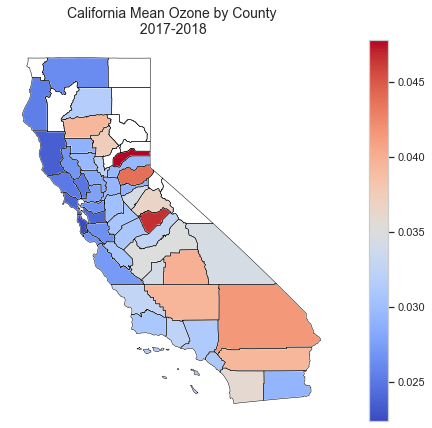

In [251]:
#plot ozone map
fig = plt.figure(1, figsize=(12,7)) 
ax = fig.add_subplot()
ax.set_title('California Mean Ozone by County\n 2017-2018', fontsize=14)
ax.set_axis_off()

californiaCountyMap.boundary.plot(ax=ax, color = 'black', linewidth=.5)
calOzoneMap.plot(ax = ax, column='Ozone Mean',legend=True, cmap='coolwarm')

In [252]:
plt.close()

In [253]:
#merge California county map with California asthma, 2017-2018
calAsthma = pd.merge(californiaCountyMap, asthmaCalFinal, left_on=californiaCountyMap['NAME'], 
                right_on=asthmaCalFinal['COUNTY'], how='left')
calAsthma

,key_0,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,COUNTY,YEARS,STRATA,AGE GROUP,CURRENT PREVALENCE,95% CONFIDENCE INTERVAL,COUNTIES GROUPED,COMMENT
0,Trinity,06,105,00277317,0500000US06105,06105,Trinity,06,8234308375,73407838,"POLYGON Z ((-123.62366 40.92982 0.00000, -123....",Trinity,2017–2018,Child vs. adult,18+ years,13.8676,(4.9–22.9),"Del Norte, Lassen, Modoc, Plumas, Sierra, Sisk...",Estimate is statistically unstable. Caution is...
1,San Luis Obispo,06,079,00277304,0500000US06079,06079,San Luis Obispo,06,8543720566,820409436,"POLYGON Z ((-121.34636 35.79518 0.00000, -121....",San Luis Obispo,2017–2018,Child vs. adult,18+ years,6.4168,(2.5–10.4),NaN,Estimate is statistically unstable. Caution is...
2,Shasta,06,089,01682610,0500000US06089,06089,Shasta,06,9778188425,186530226,"POLYGON Z ((-123.06644 40.33621 0.00000, -123....",Shasta,2017–2018,Child vs. adult,18+ years,7.5027,(3.3–11.7),NaN,NaN
3,Amador,06,005,01675841,0500000US06005,06005,Amador,06,1539947591,29470575,"POLYGON Z ((-121.02751 38.50829 0.00000, -121....",Amador,2017–2018,Child vs. adult,18+ years,17.5692,(6.7–28.5),"Alpine, Amador, Calaveras, Inyo, Mariposa, Mon...",Estimate is statistically unstable. Caution is...
4,San Bernardino,06,071,00277300,0500000US06071,06071,San Bernardino,06,51947497395,123929658,"POLYGON Z ((-117.78506 34.00481 0.00000, -117....",San Bernardino,2017–2018,Child vs. adult,18+ years,8.9971,(6.5–11.5),NaN,NaN
5,Monterey,06,053,00277291,0500000US06053,06053,Monterey,06,8496777466,1270701096,"POLYGON Z ((-121.97859 36.58049 0.00000, -121....",Monterey,2017–2018,Child vs. adult,18+ years,7.0750,(3.0–11.1),NaN,NaN
6,Tehama,06,103,01692767,0500000US06103,06103,Tehama,06,7639716083,32276053,"POLYGON Z ((-123.05927 40.28548 0.00000, -123....",Tehama,2017–2018,Child vs. adult,18+ years,14.8277,(6.6–23.0),"Colusa, Glenn, and Tehama counties combined co...",NaN
7,Tuolumne,06,109,00277319,0500000US06109,06109,Tuolumne,06,5752116633,138684399,"POLYGON Z ((-120.65255 37.83346 0.00000, -120....",Tuolumne,2017–2018,Child vs. adult,18+ years,17.5692,(6.7–28.5),"Alpine, Amador, Calaveras, Inyo, Mariposa, Mon...",Estimate is statistically unstable. Caution is...
8,Nevada,06,057,01682927,0500000US06057,06057,Nevada,06,2480638586,41513176,"POLYGON Z ((-121.27953 39.23054 0.00000, -121....",Nevada,2017–2018,Child vs. adult,18+ years,10.9242,(2.7–19.2),NaN,Estimate is statistically unstable. Caution is...
9,Placer,06,061,00277295,0500000US06061,06061,Placer,06,3644346108,246376805,"POLYGON Z ((-121.48444 38.75135 0.00000, -121....",Placer,2017–2018,Child vs. adult,18+ years,6.9475,(3.1–10.8),NaN,NaN


<AxesSubplot:title={'center':'California Asthma Prevalence by County\n 2017-2018'}>

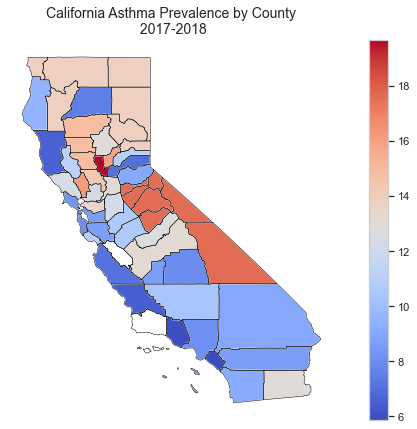

In [254]:
#plot California asthma 2017-2018 map
fig = plt.figure(1, figsize=(12,7)) 
ax = fig.add_subplot()
ax.set_title('California Asthma Prevalence by County\n 2017-2018', fontsize=14)
ax.set_axis_off()

californiaCountyMap.boundary.plot(ax=ax, color = 'black', linewidth=.5)
calAsthma.plot(ax = ax, column='CURRENT PREVALENCE',legend=True,cmap='coolwarm')

In [117]:
plt.close()

### Create scatterplots of asthma vs PM2.5 and asthma vs Ozone


#### Asthma and PM2.5

In [256]:
#merge datasets
calAsthmaPM25 = pmCaliforniaCombinedCountydf.merge(asthmaCalFinal, left_on=pmCaliforniaCombinedCountydf['County'],
                           right_on=asthmaCalFinal['COUNTY'], how='left')  

<AxesSubplot:xlabel='PM2.5 Mean', ylabel='CURRENT PREVALENCE'>

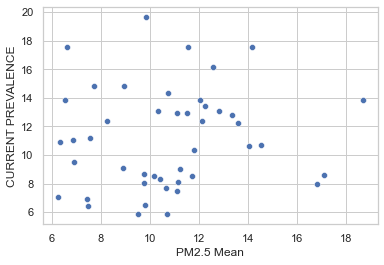

In [257]:
sns.set(style='whitegrid', context='notebook', rc={'figure.figsize':(6,4)})
sns.scatterplot(x='PM2.5 Mean', y='CURRENT PREVALENCE', data=calAsthmaPM25)

In [261]:
plt.close()

In [258]:
#calculate correlation coefficient
corrCalAsthmaPM25 = calAsthmaPM25['PM2.5 Mean'].corr(calAsthmaPM25['CURRENT PREVALENCE'])
corrCalAsthmaPM25

0.09979435147166238

#### Asthma and Ozone

In [259]:
#merge datasets
calAsthmaOzone = ozoneCaliforniaCombinedCountydf.merge(asthmaCalFinal, left_on=ozoneCaliforniaCombinedCountydf['County'],
                           right_on=asthmaCalFinal['COUNTY'], how='left')  

<AxesSubplot:xlabel='Ozone Mean', ylabel='CURRENT PREVALENCE'>

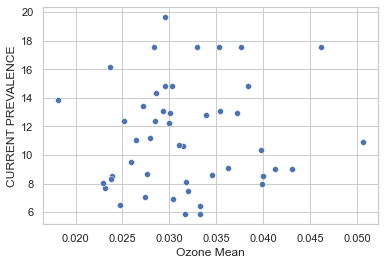

In [141]:
sns.scatterplot(x='Ozone Mean', y='CURRENT PREVALENCE', data=calAsthmaOzone)

In [142]:
plt.close()

In [260]:
#calculate correlation coefficient
corrCalAsthmaOzone = calAsthmaOzone['Ozone Mean'].corr(calAsthmaOzone['CURRENT PREVALENCE'])
corrCalAsthmaOzone

0.1441234513327162

### Explore relationship between asthma prevalence and AQI

In [152]:
AQI2017California.head()

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days SO2,Days PM2.5,Days PM10
49,California,Alameda,2017,365,189,162,9,4,1,0,205,76,49,0,14,110,0,241,0
50,California,Amador,2017,362,291,67,4,0,0,0,136,64,38,0,0,362,0,0,0
51,California,Butte,2017,365,152,189,23,1,0,0,154,94,57,0,0,218,0,145,2
52,California,Calaveras,2017,354,169,171,12,2,0,0,172,87,51,0,0,226,0,127,1
53,California,Colusa,2017,365,274,83,7,1,0,0,193,65,40,0,0,202,0,130,33


In [153]:
calAsthma

,key_0,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,COUNTY,YEARS,STRATA,AGE GROUP,CURRENT PREVALENCE,95% CONFIDENCE INTERVAL,COUNTIES GROUPED,COMMENT
0,Trinity,06,105,00277317,0500000US06105,06105,Trinity,06,8234308375,73407838,"POLYGON Z ((-123.62366 40.92982 0.00000, -123....",Trinity,2017–2018,Child vs. adult,18+ years,13.8676,(4.9–22.9),"Del Norte, Lassen, Modoc, Plumas, Sierra, Sisk...",Estimate is statistically unstable. Caution is...
1,San Luis Obispo,06,079,00277304,0500000US06079,06079,San Luis Obispo,06,8543720566,820409436,"POLYGON Z ((-121.34636 35.79518 0.00000, -121....",San Luis Obispo,2017–2018,Child vs. adult,18+ years,6.4168,(2.5–10.4),NaN,Estimate is statistically unstable. Caution is...
2,Shasta,06,089,01682610,0500000US06089,06089,Shasta,06,9778188425,186530226,"POLYGON Z ((-123.06644 40.33621 0.00000, -123....",Shasta,2017–2018,Child vs. adult,18+ years,7.5027,(3.3–11.7),NaN,NaN
3,Amador,06,005,01675841,0500000US06005,06005,Amador,06,1539947591,29470575,"POLYGON Z ((-121.02751 38.50829 0.00000, -121....",Amador,2017–2018,Child vs. adult,18+ years,17.5692,(6.7–28.5),"Alpine, Amador, Calaveras, Inyo, Mariposa, Mon...",Estimate is statistically unstable. Caution is...
4,San Bernardino,06,071,00277300,0500000US06071,06071,San Bernardino,06,51947497395,123929658,"POLYGON Z ((-117.78506 34.00481 0.00000, -117....",San Bernardino,2017–2018,Child vs. adult,18+ years,8.9971,(6.5–11.5),NaN,NaN
5,Monterey,06,053,00277291,0500000US06053,06053,Monterey,06,8496777466,1270701096,"POLYGON Z ((-121.97859 36.58049 0.00000, -121....",Monterey,2017–2018,Child vs. adult,18+ years,7.0750,(3.0–11.1),NaN,NaN
6,Tehama,06,103,01692767,0500000US06103,06103,Tehama,06,7639716083,32276053,"POLYGON Z ((-123.05927 40.28548 0.00000, -123....",Tehama,2017–2018,Child vs. adult,18+ years,14.8277,(6.6–23.0),"Colusa, Glenn, and Tehama counties combined co...",NaN
7,Tuolumne,06,109,00277319,0500000US06109,06109,Tuolumne,06,5752116633,138684399,"POLYGON Z ((-120.65255 37.83346 0.00000, -120....",Tuolumne,2017–2018,Child vs. adult,18+ years,17.5692,(6.7–28.5),"Alpine, Amador, Calaveras, Inyo, Mariposa, Mon...",Estimate is statistically unstable. Caution is...
8,Nevada,06,057,01682927,0500000US06057,06057,Nevada,06,2480638586,41513176,"POLYGON Z ((-121.27953 39.23054 0.00000, -121....",Nevada,2017–2018,Child vs. adult,18+ years,10.9242,(2.7–19.2),NaN,Estimate is statistically unstable. Caution is...
9,Placer,06,061,00277295,0500000US06061,06061,Placer,06,3644346108,246376805,"POLYGON Z ((-121.48444 38.75135 0.00000, -121....",Placer,2017–2018,Child vs. adult,18+ years,6.9475,(3.1–10.8),NaN,NaN


In [154]:
len(calAsthma)

58

In [155]:
calAsthma['CURRENT PREVALENCE'].isna()

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11     True
12    False
13    False
14    False
15     True
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39    False
40    False
41    False
42    False
43    False
44    False
45    False
46    False
47    False
48    False
49    False
50    False
51    False
52    False
53    False
54    False
55    False
56    False
57    False
Name: CURRENT PREVALENCE, dtype: bool

In [156]:
calAsthma.drop('key_0', axis = 1, inplace = True)

In [157]:
calAsthma

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,COUNTY,YEARS,STRATA,AGE GROUP,CURRENT PREVALENCE,95% CONFIDENCE INTERVAL,COUNTIES GROUPED,COMMENT
0,06,105,00277317,0500000US06105,06105,Trinity,06,8234308375,73407838,"POLYGON Z ((-123.62366 40.92982 0.00000, -123....",Trinity,2017–2018,Child vs. adult,18+ years,13.8676,(4.9–22.9),"Del Norte, Lassen, Modoc, Plumas, Sierra, Sisk...",Estimate is statistically unstable. Caution is...
1,06,079,00277304,0500000US06079,06079,San Luis Obispo,06,8543720566,820409436,"POLYGON Z ((-121.34636 35.79518 0.00000, -121....",San Luis Obispo,2017–2018,Child vs. adult,18+ years,6.4168,(2.5–10.4),NaN,Estimate is statistically unstable. Caution is...
2,06,089,01682610,0500000US06089,06089,Shasta,06,9778188425,186530226,"POLYGON Z ((-123.06644 40.33621 0.00000, -123....",Shasta,2017–2018,Child vs. adult,18+ years,7.5027,(3.3–11.7),NaN,NaN
3,06,005,01675841,0500000US06005,06005,Amador,06,1539947591,29470575,"POLYGON Z ((-121.02751 38.50829 0.00000, -121....",Amador,2017–2018,Child vs. adult,18+ years,17.5692,(6.7–28.5),"Alpine, Amador, Calaveras, Inyo, Mariposa, Mon...",Estimate is statistically unstable. Caution is...
4,06,071,00277300,0500000US06071,06071,San Bernardino,06,51947497395,123929658,"POLYGON Z ((-117.78506 34.00481 0.00000, -117....",San Bernardino,2017–2018,Child vs. adult,18+ years,8.9971,(6.5–11.5),NaN,NaN
5,06,053,00277291,0500000US06053,06053,Monterey,06,8496777466,1270701096,"POLYGON Z ((-121.97859 36.58049 0.00000, -121....",Monterey,2017–2018,Child vs. adult,18+ years,7.0750,(3.0–11.1),NaN,NaN
6,06,103,01692767,0500000US06103,06103,Tehama,06,7639716083,32276053,"POLYGON Z ((-123.05927 40.28548 0.00000, -123....",Tehama,2017–2018,Child vs. adult,18+ years,14.8277,(6.6–23.0),"Colusa, Glenn, and Tehama counties combined co...",NaN
7,06,109,00277319,0500000US06109,06109,Tuolumne,06,5752116633,138684399,"POLYGON Z ((-120.65255 37.83346 0.00000, -120....",Tuolumne,2017–2018,Child vs. adult,18+ years,17.5692,(6.7–28.5),"Alpine, Amador, Calaveras, Inyo, Mariposa, Mon...",Estimate is statistically unstable. Caution is...
8,06,057,01682927,0500000US06057,06057,Nevada,06,2480638586,41513176,"POLYGON Z ((-121.27953 39.23054 0.00000, -121....",Nevada,2017–2018,Child vs. adult,18+ years,10.9242,(2.7–19.2),NaN,Estimate is statistically unstable. Caution is...
9,06,061,00277295,0500000US06061,06061,Placer,06,3644346108,246376805,"POLYGON Z ((-121.48444 38.75135 0.00000, -121....",Placer,2017–2018,Child vs. adult,18+ years,6.9475,(3.1–10.8),NaN,NaN


In [158]:
#drop counties with NaN values for current prevalence
calAsthma.drop(labels = [11, 15], axis=0, inplace = True)

In [159]:
#merge asthma and California shapefile with California AQI that has observations for 2017
#in order to have more data to plot
calAsthmaAQI2017 = AQI2017California.merge(calAsthma, left_on=AQI2017California['County'],
                           right_on=calAsthma['NAME'], how='left')                
calAsthmaAQI2017

,key_0,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,...,AWATER,geometry,COUNTY,YEARS,STRATA,AGE GROUP,CURRENT PREVALENCE,95% CONFIDENCE INTERVAL,COUNTIES GROUPED,COMMENT
0,Alameda,California,Alameda,2017,365,189,162,9,4,1,...,2.129818e+08,"POLYGON Z ((-122.33371 37.80980 0.00000, -122....",Alameda,2017–2018,Child vs. adult,18+ years,8.5585,(5.5–11.6),NaN,NaN
1,Amador,California,Amador,2017,362,291,67,4,0,0,...,2.947058e+07,"POLYGON Z ((-121.02751 38.50829 0.00000, -121....",Amador,2017–2018,Child vs. adult,18+ years,17.5692,(6.7–28.5),"Alpine, Amador, Calaveras, Inyo, Mariposa, Mon...",Estimate is statistically unstable. Caution is...
2,Butte,California,Butte,2017,365,152,189,23,1,0,...,1.053257e+08,"POLYGON Z ((-122.06943 39.84053 0.00000, -122....",Butte,2017–2018,Child vs. adult,18+ years,12.9290,(6.3–19.5),NaN,NaN
3,Calaveras,California,Calaveras,2017,354,169,171,12,2,0,...,4.380875e+07,"POLYGON Z ((-120.98563 38.22139 0.00000, -120....",Calaveras,2017–2018,Child vs. adult,18+ years,17.5692,(6.7–28.5),"Alpine, Amador, Calaveras, Inyo, Mariposa, Mon...",Estimate is statistically unstable. Caution is...
4,Colusa,California,Colusa,2017,365,274,83,7,1,0,...,1.458104e+07,"POLYGON Z ((-122.77110 39.32468 0.00000, -122....",Colusa,2017–2018,Child vs. adult,18+ years,14.8277,(6.6–23.0),"Colusa, Glenn, and Tehama counties combined co...",NaN
5,Contra Costa,California,Contra Costa,2017,365,222,131,8,4,0,...,2.098552e+08,"POLYGON Z ((-122.42976 37.96540 0.00000, -122....",Contra Costa,2017–2018,Child vs. adult,18+ years,13.4571,(9.1–17.8),NaN,NaN
6,Del Norte,California,Del Norte,2017,298,270,26,0,1,1,...,5.785257e+08,"POLYGON Z ((-124.25599 41.78301 0.00000, -124....",Del Norte,2017–2018,Child vs. adult,18+ years,13.8676,(4.9–22.9),"Del Norte, Lassen, Modoc, Plumas, Sierra, Sisk...",Estimate is statistically unstable. Caution is...
7,El Dorado,California,El Dorado,2017,362,235,96,31,0,0,...,2.033563e+08,"POLYGON Z ((-121.13451 38.71203 0.00000, -121....",El Dorado,2017–2018,Child vs. adult,18+ years,9.0343,(1.8–16.3),NaN,Estimate is statistically unstable. Caution is...
8,Fresno,California,Fresno,2017,365,102,143,93,26,1,...,1.354023e+08,"POLYGON Z ((-120.65595 36.95283 0.00000, -120....",Fresno,2017–2018,Child vs. adult,18+ years,13.0974,(8.3–17.9),NaN,NaN
9,Glenn,California,Glenn,2017,365,284,74,7,0,0,...,3.374928e+07,"POLYGON Z ((-122.93765 39.79816 0.00000, -122....",Glenn,2017–2018,Child vs. adult,18+ years,14.8277,(6.6–23.0),"Colusa, Glenn, and Tehama counties combined co...",NaN


In [160]:
calAsthmaAQI2017.columns

Index(['key_0', 'State', 'County', 'Year', 'Days with AQI', 'Good Days',
       'Moderate Days', 'Unhealthy for Sensitive Groups Days',
       'Unhealthy Days', 'Very Unhealthy Days', 'Hazardous Days', 'Max AQI',
       '90th Percentile AQI', 'Median AQI', 'Days CO', 'Days NO2',
       'Days Ozone', 'Days SO2', 'Days PM2.5', 'Days PM10', 'STATEFP',
       'COUNTYFP', 'COUNTYNS', 'AFFGEOID', 'GEOID', 'NAME', 'LSAD', 'ALAND',
       'AWATER', 'geometry', 'COUNTY', 'YEARS', 'STRATA', 'AGE GROUP',
       'CURRENT PREVALENCE', '95% CONFIDENCE INTERVAL', 'COUNTIES GROUPED',
       'COMMENT'],
      dtype='object')

In [161]:
#rename columns
calAsthmaAQI2017 = calAsthmaAQI2017.rename(columns = {'Unhealthy for Sensitive Groups Days': 'U for SG Days', 
                                                      'CURRENT PREVALENCE': 'Asthma Prevalence' })

In [162]:
#specify initial columns of interest
cols =  ['Good Days','U for SG Days', 'Unhealthy Days',
         'Very Unhealthy Days', 'Hazardous Days', 'Max AQI',
        '90th Percentile AQI','Median AQI', 'Days CO', 'Days NO2',
       'Days Ozone', 'Days SO2', 'Days PM2.5', 'Days PM10','Asthma Prevalence']

In [163]:
calAsthmaAQI2017Plotting = calAsthmaAQI2017[cols].copy()
calAsthmaAQI2017Plotting.describe()

,Good Days,U for SG Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days SO2,Days PM2.5,Days PM10,Asthma Prevalence
count,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.0,53.000000,53.000000,53.000000,53.000000,53.000000,51.000000
mean,205.264151,24.867925,6.981132,1.037736,0.528302,288.301887,88.433962,49.037736,0.0,3.981132,212.849057,0.018868,122.962264,17.471698,11.625231
std,81.266454,29.164017,11.551707,3.441613,2.232658,516.520183,31.554294,15.161898,0.0,9.030910,87.371971,0.137361,73.873323,49.092379,3.687795
min,31.000000,0.000000,0.000000,0.000000,0.000000,117.000000,44.000000,18.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,5.840300
25%,152.000000,6.000000,1.000000,0.000000,0.000000,154.000000,64.000000,39.000000,0.0,0.000000,172.000000,0.000000,94.000000,0.000000,8.550750
50%,221.000000,9.000000,3.000000,0.000000,0.000000,169.000000,82.000000,45.000000,0.0,0.000000,219.000000,0.000000,116.000000,2.000000,11.188700
75%,273.000000,33.000000,6.000000,0.000000,0.000000,197.000000,100.000000,54.000000,0.0,2.000000,253.000000,0.000000,155.000000,14.000000,13.867600
max,350.000000,115.000000,51.000000,23.000000,15.000000,3439.000000,185.000000,87.000000,0.0,47.000000,362.000000,1.000000,351.000000,341.000000,19.675200


In [164]:
#remove the days CO and days SO2 from the cols list because they zero or max of 1.
cols = ['Good Days','U for SG Days', 'Unhealthy Days',
       'Very Unhealthy Days', 'Hazardous Days', 'Max AQI',
        '90th Percentile AQI','Median AQI', 'Days NO2',
       'Days Ozone', 'Days PM2.5', 'Days PM10','Asthma Prevalence']

In [165]:
calAsthmaAQI2017Plotting = calAsthmaAQI2017[cols].copy()
calAsthmaAQI2017Plotting.describe()

,Good Days,U for SG Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days NO2,Days Ozone,Days PM2.5,Days PM10,Asthma Prevalence
count,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,51.000000
mean,205.264151,24.867925,6.981132,1.037736,0.528302,288.301887,88.433962,49.037736,3.981132,212.849057,122.962264,17.471698,11.625231
std,81.266454,29.164017,11.551707,3.441613,2.232658,516.520183,31.554294,15.161898,9.030910,87.371971,73.873323,49.092379,3.687795
min,31.000000,0.000000,0.000000,0.000000,0.000000,117.000000,44.000000,18.000000,0.000000,0.000000,0.000000,0.000000,5.840300
25%,152.000000,6.000000,1.000000,0.000000,0.000000,154.000000,64.000000,39.000000,0.000000,172.000000,94.000000,0.000000,8.550750
50%,221.000000,9.000000,3.000000,0.000000,0.000000,169.000000,82.000000,45.000000,0.000000,219.000000,116.000000,2.000000,11.188700
75%,273.000000,33.000000,6.000000,0.000000,0.000000,197.000000,100.000000,54.000000,2.000000,253.000000,155.000000,14.000000,13.867600
max,350.000000,115.000000,51.000000,23.000000,15.000000,3439.000000,185.000000,87.000000,47.000000,362.000000,351.000000,341.000000,19.675200


In [166]:
#create a correlation matrix with heatmap

In [167]:
calAsthmaAQI2017Plotting

,Good Days,U for SG Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days NO2,Days Ozone,Days PM2.5,Days PM10,Asthma Prevalence
0,189,9,4,1,0,205,76,49,14,110,241,0,8.5585
1,291,4,0,0,0,136,64,38,0,362,0,0,17.5692
2,152,23,1,0,0,154,94,57,0,218,145,2,12.9290
3,169,12,2,0,0,172,87,51,0,226,127,1,17.5692
4,274,7,1,0,0,193,65,40,0,202,130,33,14.8277
5,222,8,4,0,0,169,72,46,1,138,226,0,13.4571
6,270,0,1,1,0,226,49,20,0,0,298,0,13.8676
7,235,31,0,0,0,147,100,45,0,327,6,29,9.0343
8,102,93,26,1,0,207,140,74,2,234,116,13,13.0974
9,284,7,0,0,0,150,59,43,0,207,115,43,14.8277


In [168]:
#drop rows with NaN first

In [169]:
calAsthmaAQI2017Plotting.drop(labels=[31, 38], axis=0, inplace=True)

In [170]:
#correlation matrix with heatmap code from CIS5400, Python and Data Science
calAsthmaAQI2017Plotting.values
calAsthmaAQI2017Plotting.values.T
cm = np.corrcoef(calAsthmaAQI2017Plotting.values.T)

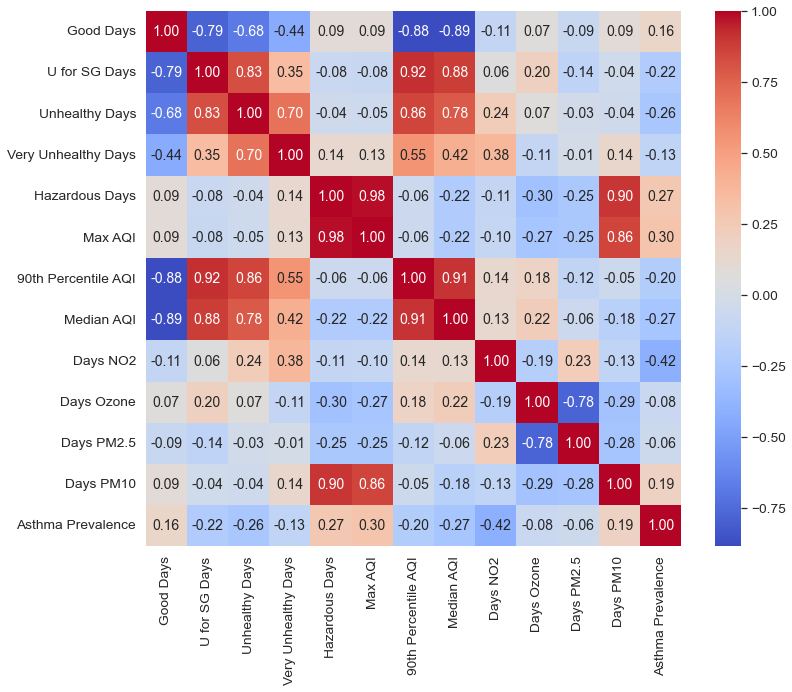

In [171]:
sns.set(font_scale=1.25)
#cbar - boolean to specify whether or not to draw the color bar
#annot - boolean to specify whether or not to annotate the heatmap
#square - boolean to specify whether or not to set the Axes aspect 
#to “equal” so each cell will be square-shaped.
#fmt='.2f' - string formatting code to use when adding annotations
#annot_kws - dict of key, value mappings, optional keyword arguments for 
#matplotlib.axes.Axes.text() when annot is True
fig, ax = plt.subplots(figsize=(12,12))

hm = sns.heatmap(cm, cmap='coolwarm', cbar=True, cbar_kws={"shrink": 0.82}, annot=True,square=True,fmt='.2f',
                annot_kws={'size':14},yticklabels=cols,xticklabels=cols,
                ax=ax)

In [172]:
plt.close()

In [173]:
#merge asthma and California shapefile with California AQI that has observations for 2018
#in order to have more data to plot
calAsthmaAQI2018 = AQI2018California.merge(calAsthma, left_on=AQI2018California['County'],
                           right_on=calAsthma['NAME'], how='left')                
calAsthmaAQI2018

,key_0,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,...,AWATER,geometry,COUNTY,YEARS,STRATA,AGE GROUP,CURRENT PREVALENCE,95% CONFIDENCE INTERVAL,COUNTIES GROUPED,COMMENT
0,Alameda,California,Alameda,2018,365,175,173,5,10,2,...,2.129818e+08,"POLYGON Z ((-122.33371 37.80980 0.00000, -122....",Alameda,2017–2018,Child vs. adult,18+ years,8.5585,(5.5–11.6),NaN,NaN
1,Amador,California,Amador,2018,364,288,70,6,0,0,...,2.947058e+07,"POLYGON Z ((-121.02751 38.50829 0.00000, -121....",Amador,2017–2018,Child vs. adult,18+ years,17.5692,(6.7–28.5),"Alpine, Amador, Calaveras, Inyo, Mariposa, Mon...",Estimate is statistically unstable. Caution is...
2,Butte,California,Butte,2018,365,152,173,22,11,3,...,1.053257e+08,"POLYGON Z ((-122.06943 39.84053 0.00000, -122....",Butte,2017–2018,Child vs. adult,18+ years,12.9290,(6.3–19.5),NaN,NaN
3,Calaveras,California,Calaveras,2018,364,148,196,14,6,0,...,4.380875e+07,"POLYGON Z ((-120.98563 38.22139 0.00000, -120....",Calaveras,2017–2018,Child vs. adult,18+ years,17.5692,(6.7–28.5),"Alpine, Amador, Calaveras, Inyo, Mariposa, Mon...",Estimate is statistically unstable. Caution is...
4,Colusa,California,Colusa,2018,365,245,92,10,17,1,...,1.458104e+07,"POLYGON Z ((-122.77110 39.32468 0.00000, -122....",Colusa,2017–2018,Child vs. adult,18+ years,14.8277,(6.6–23.0),"Colusa, Glenn, and Tehama counties combined co...",NaN
5,Contra Costa,California,Contra Costa,2018,365,203,144,7,9,2,...,2.098552e+08,"POLYGON Z ((-122.42976 37.96540 0.00000, -122....",Contra Costa,2017–2018,Child vs. adult,18+ years,13.4571,(9.1–17.8),NaN,NaN
6,Del Norte,California,Del Norte,2018,180,162,18,0,0,0,...,5.785257e+08,"POLYGON Z ((-124.25599 41.78301 0.00000, -124....",Del Norte,2017–2018,Child vs. adult,18+ years,13.8676,(4.9–22.9),"Del Norte, Lassen, Modoc, Plumas, Sierra, Sisk...",Estimate is statistically unstable. Caution is...
7,El Dorado,California,El Dorado,2018,365,222,106,27,9,1,...,2.033563e+08,"POLYGON Z ((-121.13451 38.71203 0.00000, -121....",El Dorado,2017–2018,Child vs. adult,18+ years,9.0343,(1.8–16.3),NaN,Estimate is statistically unstable. Caution is...
8,Fresno,California,Fresno,2018,365,84,183,79,19,0,...,1.354023e+08,"POLYGON Z ((-120.65595 36.95283 0.00000, -120....",Fresno,2017–2018,Child vs. adult,18+ years,13.0974,(8.3–17.9),NaN,NaN
9,Glenn,California,Glenn,2018,363,275,72,9,6,1,...,3.374928e+07,"POLYGON Z ((-122.93765 39.79816 0.00000, -122....",Glenn,2017–2018,Child vs. adult,18+ years,14.8277,(6.6–23.0),"Colusa, Glenn, and Tehama counties combined co...",NaN


In [174]:
calAsthmaAQI2018.columns

Index(['key_0', 'State', 'County', 'Year', 'Days with AQI', 'Good Days',
       'Moderate Days', 'Unhealthy for Sensitive Groups Days',
       'Unhealthy Days', 'Very Unhealthy Days', 'Hazardous Days', 'Max AQI',
       '90th Percentile AQI', 'Median AQI', 'Days CO', 'Days NO2',
       'Days Ozone', 'Days SO2', 'Days PM2.5', 'Days PM10', 'STATEFP',
       'COUNTYFP', 'COUNTYNS', 'AFFGEOID', 'GEOID', 'NAME', 'LSAD', 'ALAND',
       'AWATER', 'geometry', 'COUNTY', 'YEARS', 'STRATA', 'AGE GROUP',
       'CURRENT PREVALENCE', '95% CONFIDENCE INTERVAL', 'COUNTIES GROUPED',
       'COMMENT'],
      dtype='object')

In [175]:
#rename columns
calAsthmaAQI2018 = calAsthmaAQI2018.rename(columns = {'Unhealthy for Sensitive Groups Days': 'U for SG Days', 
                                                      'CURRENT PREVALENCE': 'Asthma Prevalence' })

In [176]:
#specify initial columns of interest
cols =  ['Good Days','U for SG Days', 'Unhealthy Days',
       'Very Unhealthy Days', 'Hazardous Days', 'Max AQI',
        '90th Percentile AQI','Median AQI', 'Days CO', 'Days NO2',
       'Days Ozone', 'Days SO2', 'Days PM2.5', 'Days PM10','Asthma Prevalence']

In [177]:
calAsthmaAQI2018Plotting = calAsthmaAQI2018[cols].copy()
calAsthmaAQI2018Plotting.describe()

,Good Days,U for SG Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days SO2,Days PM2.5,Days PM10,Asthma Prevalence
count,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,51.000000
mean,206.566038,23.226415,9.679245,1.132075,0.226415,231.113208,87.320755,48.792453,0.037736,4.113208,201.641509,0.018868,138.679245,14.716981,11.625231
std,83.329630,27.851006,9.281441,1.829646,0.669142,136.877635,27.802721,14.714408,0.192380,8.554487,88.386628,0.137361,75.463127,30.029074,3.687795
min,35.000000,0.000000,0.000000,0.000000,0.000000,77.000000,43.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.840300
25%,153.000000,5.000000,5.000000,0.000000,0.000000,166.000000,64.000000,39.000000,0.000000,0.000000,154.000000,0.000000,94.000000,0.000000,8.550750
50%,219.000000,14.000000,8.000000,0.000000,0.000000,196.000000,84.000000,45.000000,0.000000,0.000000,203.000000,0.000000,136.000000,1.000000,11.188700
75%,275.000000,26.000000,11.000000,2.000000,0.000000,240.000000,101.000000,54.000000,0.000000,2.000000,246.000000,0.000000,192.000000,12.000000,13.867600
max,347.000000,103.000000,51.000000,8.000000,4.000000,994.000000,164.000000,88.000000,1.000000,34.000000,364.000000,1.000000,350.000000,147.000000,19.675200


In [178]:
#create correlation matrix with heatmap

In [179]:
calAsthmaAQI2018Plotting

,Good Days,U for SG Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days SO2,Days PM2.5,Days PM10,Asthma Prevalence
0,175,5,10,2,0,223,76,51,0,10,72,0,283,0,8.5585
1,288,6,0,0,0,129,71,40,0,0,364,0,0,0,17.5692
2,152,22,11,3,4,445,104,54,0,0,203,0,161,1,12.9290
3,148,14,6,0,0,157,87,53,0,0,141,0,223,0,17.5692
4,245,10,17,1,0,274,81,42,0,0,176,0,155,34,14.8277
5,203,7,9,2,0,245,71,48,0,1,107,1,256,0,13.4571
6,162,0,0,0,0,77,52,25,0,0,0,0,180,0,13.8676
7,222,27,9,1,0,203,101,45,0,0,353,0,3,9,9.0343
8,84,79,19,0,0,185,133,74,0,3,231,0,121,10,13.0974
9,275,9,6,1,0,230,69,36,0,0,154,0,136,73,14.8277


In [180]:
#drop rows with NaN

In [181]:
calAsthmaAQI2018Plotting.drop(labels=[31, 38], axis=0, inplace=True)

In [182]:
#correlation matrix with heatmap code from CIS5400, Python and Data Science
calAsthmaAQI2018Plotting.values
calAsthmaAQI2018Plotting.values.T
cm18 = np.corrcoef(calAsthmaAQI2018Plotting.values.T)

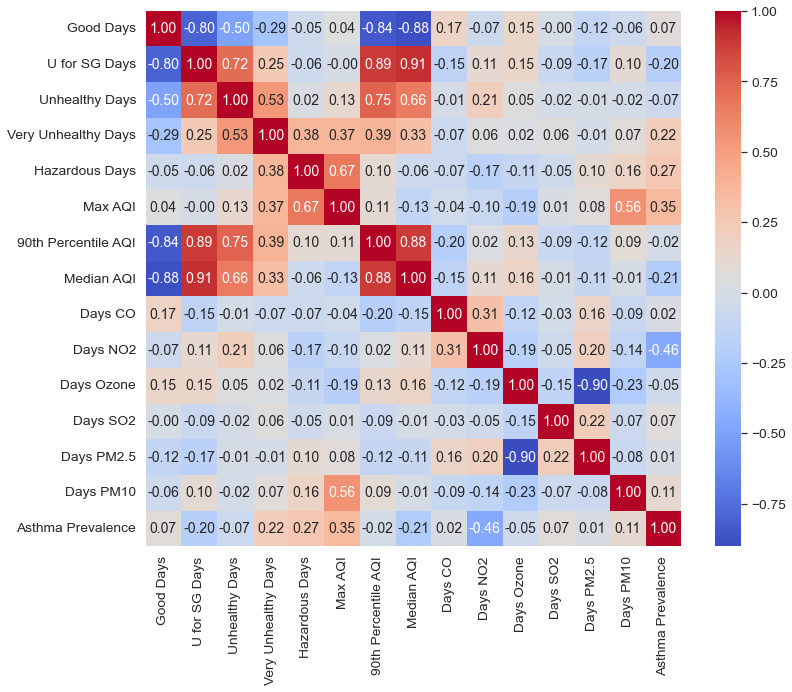

In [183]:
sns.set(font_scale=1.25)
#cbar - boolean to specify whether or not to draw the color bar
#annot - boolean to specify whether or not to annotate the heatmap
#square - boolean to specify whether or not to set the Axes aspect 
#to “equal” so each cell will be square-shaped.
#fmt='.2f' - string formatting code to use when adding annotations
#annot_kws - dict of key, value mappings, optional keyword arguments for 
#matplotlib.axes.Axes.text() when annot is True
fig, ax = plt.subplots(figsize=(12,12))

hm = sns.heatmap(cm18, cmap='coolwarm', cbar=True, cbar_kws={"shrink": 0.82}, annot=True,square=True,fmt='.2f',
                annot_kws={'size':14},yticklabels=cols,xticklabels=cols,
                ax=ax)

In [184]:
plt.close()